# Neural Networks

Neural networks are the workhorse of breakthroughs in machine learning in the last decade. The reason for this is that they are able to learn complex non-linear relationships between inputs and outputs. In this notebook, we will explore the basics of neural networks and how to implement them in Python.

For simplicity, we'll use so-called fully connected deep neural networks. It sounds mysterios, but it's just a function, given by 

$y = f(x) = \sigma(W_2 \sigma(W_1 x + b_1) + b_2)$

where $x$ is the input, $y$ is the output, $W_1$ and $W_2$ are matrices of weights, $b_1$ and $b_2$ are vectors of biases, and $\sigma$ is a non-linear function called the activation function. The activation function is applied element-wise to its input.  The number of layers in the network is the depth of the network, and the number of neurons in each layer is the width of the network. The number of neurons in the input layer is the dimensionality of the input, and the number of neurons in the output layer is the dimensionality of the output.

The weights and biases are the parameters of the neural network. When the neural network is initialized on your computer these are drawn randomly from a distribution, but the process of machine learning involves some optimization process on the parameters to achieve some goal -- winning at chess, generating fake images of galaxies, classifying phases of matter, etc etc.  Parameters that are not updated during learning are called hyperparameters. The depth and width of the network are hyperparameters in this example.

# Jax

The libraries we'll use for neural networks are `jax` + `flax`. `jax` is a library for automatic differentiation and vectorization, and `flax` is a library for neural networks built on top of `jax`.  `jax` is a bit like `numpy` but with automatic differentiation.  Other very popular neural network libraries include `tensorflow` and `pytorch`.

There are a few essential functions / features in jax that you have to get used to before you worry about neural networks. They are 
- `jax.numpy` which is a version of `numpy` that can be differentiated
- `jax.vmap` which is a function that vectorizes a function
- `jax.grad` which is a function that computes the gradient of a function
- `jax.jit` which is a function that compiles a function for faster execution

In [1]:
import jax.numpy as jnp
from jax import grad, vmap, jit
import math

Let's check out `grad`, which we've seen previously.

In [3]:
jnp.sin(2*math.pi)

Array(1.7484555e-07, dtype=float32, weak_type=True)

In [5]:
grad_sin = grad(jnp.sin) # takes the gradient of sin
print(grad_sin(2*math.pi))

1.0


What if I want to compute the gradient of a function that takes a vector as input?  Let's try it out.

In [7]:
grad_vec_input = vmap(grad_sin) # takes the gradient of sin for each element in the input
print(grad_vec_input(jnp.array([0., math.pi/4, math.pi/2, 3*math.pi/4, math.pi])))

[ 1.0000000e+00  7.0710677e-01 -4.3711388e-08 -7.0710677e-01
 -1.0000000e+00]


This demonstrates `vmap`, which is a function that vectorizes a function. Note I can't use it on a single input. Can I use it on a vector with a slightly different shape?

In [11]:
grad_vec_input(jnp.array([2*math.pi]))
print(grad_vec_input(jnp.array([[0.], [math.pi/4], [math.pi/2],[ 3*math.pi/4], [math.pi/2]])))

TypeError: Gradient only defined for scalar-output functions. Output had shape: (1,).

What's the difference? One gives a scalar on this input, the other technically does not even though it has the same numbers in it. It's about the shape.

In [13]:
my_array = jnp.array([[0.], [math.pi/4], [math.pi/2],[ 3*math.pi/4], [math.pi/2]])
print(my_array.shape)
print(my_array.squeeze().shape)

(5, 1)
(5,)


In [15]:
aarons_function = lambda x: jnp.cos(x**2)

In [17]:
aarons_function(jnp.array(1.0))

Array(0.5403023, dtype=float32, weak_type=True)

In [19]:
squeezed_sin = lambda x: jnp.sin(x).squeeze()
grad_vec_input_take2 = vmap(grad(squeezed_sin))
print(grad_vec_input_take2(my_array))

[[ 1.0000000e+00]
 [ 7.0710677e-01]
 [-4.3711388e-08]
 [-7.0710677e-01]
 [-4.3711388e-08]]


The vmap knows what to do with the first index. It's the second index that is the issue here.

**Okay, jax is just faster?!** Is that the reason to use it? Yes, `jax` is a bit faster if you are dealing with large arrays.

In [21]:
import numpy as np

In [23]:
%%time
vec_input = vmap(jnp.sin)
a_million_random_numbers = np.random.uniform(0, 2*math.pi, (1000000,))
vec_input(a_million_random_numbers)

CPU times: total: 15.6 ms
Wall time: 30.1 ms


Array([ 0.94342   ,  0.9563465 ,  0.88364685, ..., -0.85603565,
       -0.76806736, -0.8650824 ], dtype=float32)

In [27]:
%%time
other_way_to_compute = [jnp.sin(x) for x in a_million_random_numbers]

CPU times: total: 11.9 s
Wall time: 13.3 s


### A Toy Neural Network: Linear Regression

A neural network is just a function with parameters!? That means we know them from middle school: 

$y=mx + b$ 

is a function with parameters. This is an extremely simple neural network, and we wish to remind ourselves of the basic training scheme, using `jax` to do linear regression.

First we generate some noise data around the line

$y=10 x + 4$

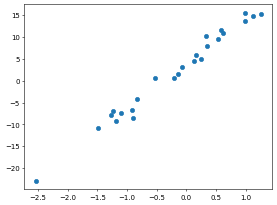

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.dpi'] = 50

num_points = 25

xs = np.random.normal(size=(num_points,1))
noise = np.random.normal(scale=1.,size=(num_points,1))
ys = 10*xs + 4 + noise

plt.scatter(xs,ys)

Imagine that we didn't generate this data ourselves, instead that some experiment gave it to us. We want to fit a model to it. In this case we know 

$f(x) = mx + b$ 

is a good model, but a prior in an experimental setup we wouldn't know that. Still, let's proceed, by defining the model itself.

In [31]:
def f(theta, x):
    m, b = theta
    return m*x + b

Now, for any specific values of $m$ and $b$, $f(x)$ makes predictions, and we want to know whether those predictions are good or bad relative to the ground truth values encoded in the variable `ys`. For that, we need a loss function, we'll use mean-squared error (MSE).

In [37]:
def mse(theta, x, y):
    return jnp.mean((f(theta,x) - y)**2)

We want to train this function to make better predictions, i.e. we want to move in parameter space to make the predictions better. For that, we use a gradient descent update.

In [33]:
def update(theta, x, y, lr=0.1):
    loss = mse(theta, x, y)
    grad_loss = grad(mse)(theta, x, y)
    new_params = theta - lr*grad_loss
    return loss, new_params

Now that we have our data, defined a parametric model that we want to model the data with, and defined a loss function, we can train the model. We'll do this in a loop, and plot the loss as a function of the number of training steps.

This loop is the 'train loop.' It starts with the definition of an initial point in model space, i.e., an initial value for the parameters theta.

Loss at epoch 0 is 100.831
Loss at epoch 5 is 19.118
Loss at epoch 10 is 5.034
Loss at epoch 15 is 2.421
Loss at epoch 20 is 1.922
Loss at epoch 25 is 1.826
Loss at epoch 30 is 1.807
Loss at epoch 35 is 1.804
Loss at epoch 40 is 1.803
Loss at epoch 45 is 1.803
Loss at epoch 50 is 1.803
Loss at epoch 55 is 1.803
Loss at epoch 60 is 1.803
Loss at epoch 65 is 1.803
Loss at epoch 70 is 1.803
Loss at epoch 75 is 1.803
Loss at epoch 80 is 1.803
Loss at epoch 85 is 1.803
Loss at epoch 90 is 1.803
Loss at epoch 95 is 1.803
Loss at epoch 100 is 1.803


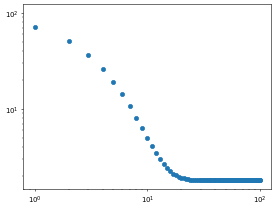

In [39]:
theta = jnp.array([0., 0.])

num_epochs, losses = 100, []
for epoch in range(num_epochs+1):
    loss, theta = update(theta, xs, ys)
    if epoch % 5 == 0: print(f"Loss at epoch {epoch} is {loss:.3f}")
    losses.append(loss)

plt.xscale('log')
plt.yscale('log')
plt.scatter(list(range(num_epochs+1)), losses)

Loss looks good. But is it the model we hoped for? Let's check the params.

In [41]:
theta

Array([10.384015 ,  3.9991767], dtype=float32)

### Toy Model: Mapping to Unit Circle



Let's do another problem. We want to map a point in 2D to a point on the unit circle. This is a different sort of problem -- there isn't a 'ground truth' label that I'm trying to hit with my predictor. Instead, I'm trying to satisfy a constraint, that my function

$f: \mathbb{R}^2 \rightarrow \mathbb{R}^2$

maps a point $x$ in the domain onto the unit circle. We'll impose this with a loss function

$L = \sum_i (f(x)\cdot f(x) - 1)^2$

Since $f$ is a model and therefore a function of parameters, $f=f_\theta$, we want to find 

$\theta^* = \arg \min_\theta L(\theta)$,

the value that minimize the loss. 

Let's start with a linear model again, since it worked last time

$f(x) = w \cdot x$

where $w$ and $x$ are now a matrix and vector, respectively.


In [43]:
def model(theta,x):
    w, b = theta
    return jnp.einsum('ji,ci->cj', w,x)

def unit_circle_loss(theta,x):
    fx = model(theta,x) 
    return jnp.mean((jnp.linalg.norm(fx, axis=1) - 1)**2)

def update(theta, x, lr=0.1):
    w, b = theta
    loss = unit_circle_loss(theta, x)
    grad_loss_w, grad_loss_b = grad(unit_circle_loss)(theta, x)
    new_params = [w - lr*grad_loss_w, b - lr*grad_loss_b]
    return loss, new_params

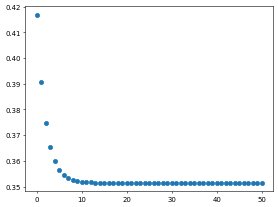

In [45]:
theta = [jnp.array([[0.5,0.5],[0.5,0.5]]), jnp.array([0.5,0.5])] 

xs = np.random.normal(size=(num_points,2))

num_epochs, losses = 50, []
for epoch in range(num_epochs+1):
    loss, theta = update(theta, xs)
    losses.append(loss)

plt.scatter(list(range(num_epochs+1)), losses)

So we see **a little** bit of improvement, but not that much really. We should be able to see that it's not that great with our naked eye!

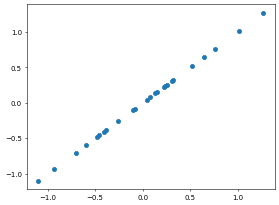

In [47]:
fx = model(theta, xs)
plt.scatter(fx[:,0], fx[:,1])

This is clearly not lying on the unit circle! It shouldn't surprise us, because this model is laughably simple and simply shouldn't be able to work for this problem.

But what if we use a more powerful model, a non-trivial feedforward neural network?

In [49]:
def model(theta, x): 
    w0, b0, w1, b1 = theta
    z = jnp.einsum('ji,ci->cj', w0, x) + b0
    z = jnp.maximum(0,z) # ReLU activation function
    output = jnp.einsum('ji,bi->bj', w1, z) + b1
    return output 

def update(theta, x, lr = 0.001):
    w0, b0, w1, b1 = theta
    loss = unit_circle_loss(theta, x)
    grad_loss_w0, grad_loss_b0, grad_loss_w1, grad_loss_b1 = grad(unit_circle_loss)(theta, x)
    new_params = [w0 - lr*grad_loss_w0, b0 - lr*grad_loss_b0, w1 - lr*grad_loss_w1, b1 - lr*grad_loss_b1]
    return loss, new_params

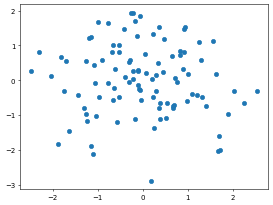

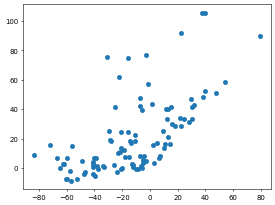

In [51]:
num_points = 100
xs = np.random.normal(size=(num_points,2))
d, width = xs.shape[1], 1024
theta = [np.random.normal(scale=1,size=(width,d)), np.zeros(width), np.random.normal(scale=1,size=(2,width)), np.zeros(2)]
 
plt.scatter(xs[:,0], xs[:,1])
plt.show()

fx = model(theta, xs)
plt.scatter(fx[:,0], fx[:,1])

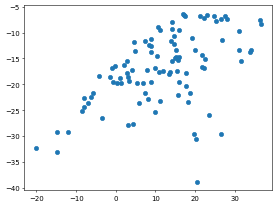

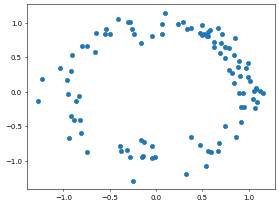

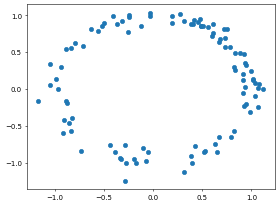

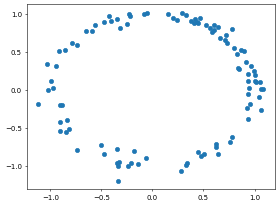

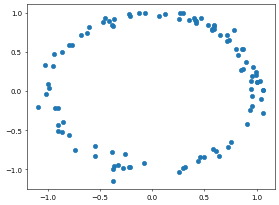

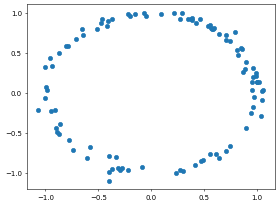

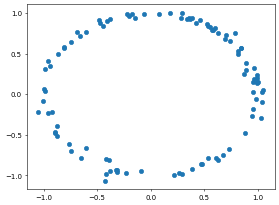

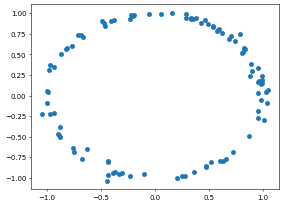

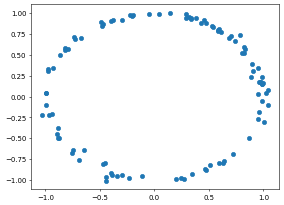

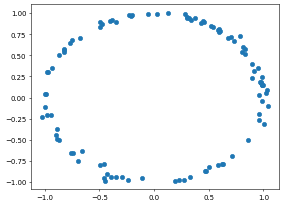

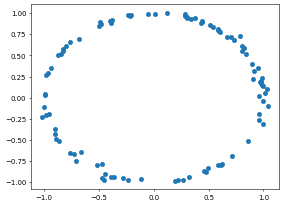

[Array(2153.1687, dtype=float32), Array(570.3304, dtype=float32), Array(286.3489, dtype=float32), Array(161.54941, dtype=float32), Array(92.466736, dtype=float32), Array(48.06058, dtype=float32), Array(24.87769, dtype=float32), Array(12.682809, dtype=float32), Array(7.7917013, dtype=float32), Array(6.174044, dtype=float32), Array(5.5198784, dtype=float32), Array(5.0265994, dtype=float32), Array(4.6117, dtype=float32), Array(4.2445045, dtype=float32), Array(3.916232, dtype=float32), Array(3.620989, dtype=float32), Array(3.3542633, dtype=float32), Array(3.1129918, dtype=float32), Array(2.8943207, dtype=float32), Array(2.6955237, dtype=float32), Array(2.5146532, dtype=float32), Array(2.3495634, dtype=float32), Array(2.1987038, dtype=float32), Array(2.0607083, dtype=float32), Array(1.9342916, dtype=float32), Array(1.8182231, dtype=float32), Array(1.7115928, dtype=float32), Array(1.6136096, dtype=float32), Array(1.5234106, dtype=float32), Array(1.440167, dtype=float32), Array(1.3633424, dty

In [53]:
num_epochs, losses, thetas = 10000, [], []
for epoch in range(num_epochs+1):
    loss, theta = update(theta,xs)
    thetas.append(theta)
    losses.append(loss)
    if epoch % 1000 == 0:
        fx = model(thetas[-1], xs)
        plt.scatter(fx[:,0], fx[:,1])
        plt.show()

print(losses)


In [55]:
theta

[Array([[-2.1642706 , -0.51669   ],
        [ 1.1350441 ,  0.9180445 ],
        [-2.1455617 ,  0.9060187 ],
        ...,
        [-0.00675997,  0.448205  ],
        [-0.9672305 , -1.3615197 ],
        [-0.38208744,  2.3152437 ]], dtype=float32),
 Array([-0.01100206, -0.00623275, -0.0006827 , ...,  0.00015851,
        -0.0024249 ,  0.00193577], dtype=float32),
 Array([[ 0.759269  ,  0.6891391 ,  0.42522666, ...,  0.47131348,
         -0.09888081, -0.41423187],
        [-0.4878058 ,  0.592082  , -2.355783  , ...,  0.6375855 ,
         -0.16703656, -0.26932654]], dtype=float32),
 Array([-0.00019286,  0.00136026], dtype=float32)]

Now: mapping things to the unit circle isnt the most useful thing in the world. But it's a good example of a problem that is hard to solve with a linear model, but easy to solve with a neural network.

The point is that this map was *learned from a constraint*, and so you might use neural networks in other situations where you want to learn something satisfying a constraint, e.g. a solution to a diff eq.

**Note:** All we plotted was train data. Does it generalize to other random draws?

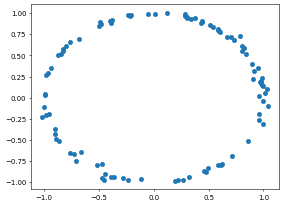

In [57]:
fx = model(theta, xs)
plt.scatter(fx[:,0], fx[:,1])

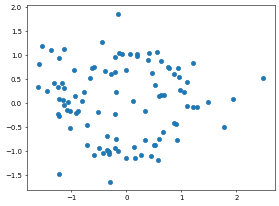

In [59]:
xs_test = np.random.normal(size=(num_points, 2))
fx = model(theta, xs_test)
plt.scatter(fx[:,0], fx[:,1])

We see it's ok on test points, but not perfect. This is called "generalization gap" or "generalization error." It's a measure of how well the model generalizes to new data.

In ML, we try to not have generalization gap, by training longer, clever choices, better optimizers, etc.